In [ ]:
import pandas as pd

file_path = "/content/data/00177.csv"
df = pd.read_csv(file_path)
print(df.head())  # Inspect the first few rows
print(df.columns)  # List all column names


   Voltage_measured  Current_measured  Temperature_measured  Current_load  \
0          4.194828          0.000474              6.097195        0.0006   
1          4.194210         -0.000864              5.733960        0.0004   
2          3.996008         -0.994037              5.579089        1.0000   
3          3.968129         -0.994147              5.522836        1.0000   
4          3.946057         -0.995820              5.437748        1.0000   

   Voltage_load    Time  
0         0.000   0.000  
1         4.210   9.343  
2         3.429  25.297  
3         3.414  40.422  
4         3.395  55.578  
Index(['Voltage_measured', 'Current_measured', 'Temperature_measured',
       'Current_load', 'Voltage_load', 'Time'],
      dtype='object')


In [13]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from google.colab import files

# Required columns for validation
required_columns = ["Voltage_measured", "Current_measured", "Temperature_measured",
                    "Current_load", "Voltage_load", "Time"]

def load_csv_data(file_path):
    try:
        # Read the CSV file
        data = pd.read_csv(file_path)
        file_columns = set(data.columns)

        # Check which required columns are missing
        missing_columns = set(required_columns) - file_columns

        # If any required columns are missing, notify the user but proceed with available data
        if missing_columns:
            print(f"File {file_path} is missing columns: {missing_columns}")
        else:
            print(f"All required columns found in {file_path}")

        return data  # Return the loaded DataFrame, even if some columns are missing

    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return pd.DataFrame()

def plot_available_data(df):
    # Check which columns are available for plotting
    available_columns = df.columns

    # If we have time and voltage (or other parameters) for plotting, we can proceed
    if 'Time' in available_columns and 'Voltage_measured' in available_columns:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=df['Time'],
            y=df['Voltage_measured'],
            mode='lines',
            name='Voltage over Time',
            line=dict(width=2, color='blue')
        ))

        fig.update_layout(
            title='Voltage over Time',
            xaxis_title='Time',
            yaxis_title='Voltage (V)',
            width=1000,
            height=800
        )
        return fig
    elif 'Time' in available_columns and 'Current_measured' in available_columns:
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=df['Time'],
            y=df['Current_measured'],
            mode='lines',
            name='Current over Time',
            line=dict(width=2, color='green')
        ))

        fig.update_layout(
            title='Current over Time',
            xaxis_title='Time',
            yaxis_title='Current (A)',
            width=1000,
            height=800
        )
        return fig
    else:
        print("No valid columns available for plotting.")
        return None

def main():
    print("Please upload your CSV file")
    uploaded = files.upload()
    for filename in uploaded.keys():
        print(f"Processing {filename}...")
        df = load_csv_data(filename)
        if not df.empty:
            fig = plot_available_data(df)
            if fig:
                fig.show()
        else:
            print("No valid data available for plotting.")

if __name__ == "__main__":
    main()


Please upload your CSV file


Saving 00001.csv to 00001.csv
Processing 00001.csv...
All required columns found in 00001.csv


In [17]:
pip install streamlit pandas matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.3 MB/s eta 0:00:00


Please upload your CSV file


Saving 00001.csv to 00001 (3).csv
Processing 00001 (3).csv...


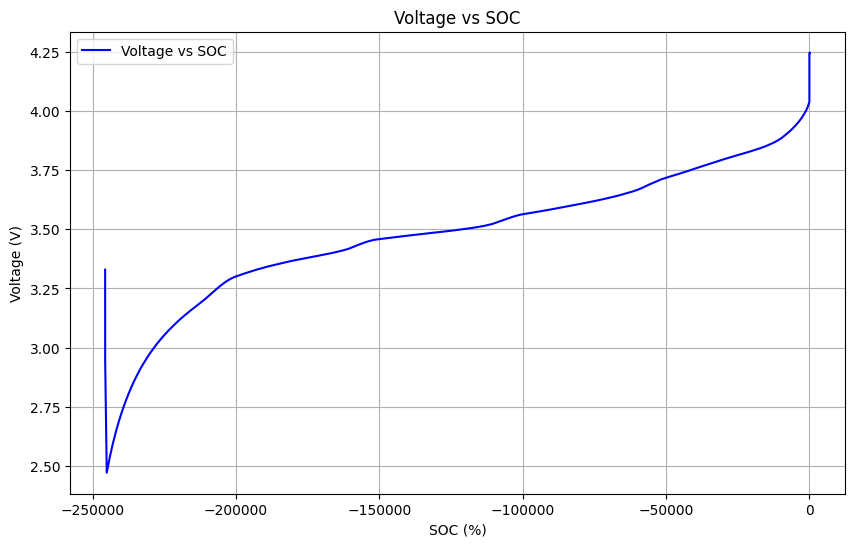

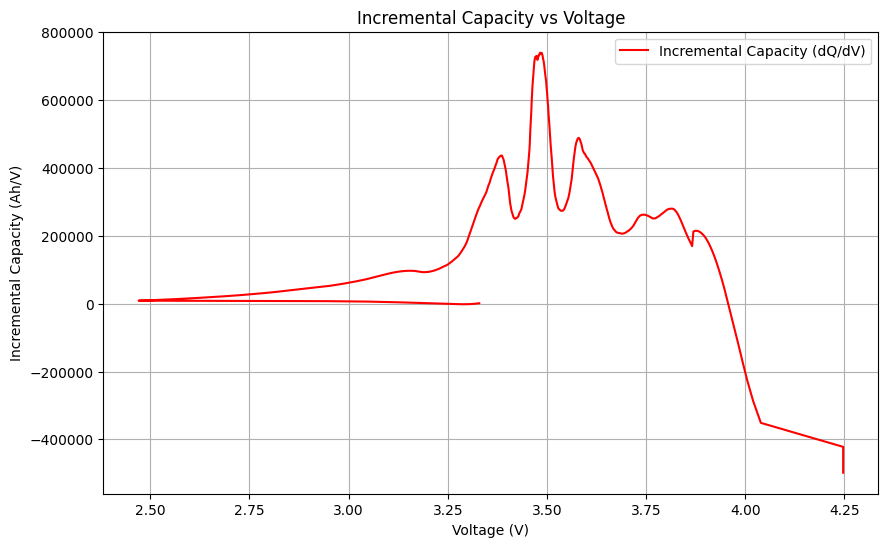

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from google.colab import files

# Function to read and process the uploaded CSV file
def read_csv_data(file_path):
    """Reads uploaded CSV file and extracts relevant columns"""
    data = pd.read_csv(file_path)

    # Define required columns
    required_columns = ["Voltage_measured", "Current_measured", "Temperature_measured",
                        "Current_load", "Voltage_load", "Time"]

    # Check if all required columns are present in the CSV
    if all(col in data.columns for col in required_columns):
        voltage = data["Voltage_measured"].values
        current = data["Current_measured"].values
        time = data["Time"].values
        return voltage, current, time
    else:
        print("Error: CSV file must contain the following columns:", required_columns)
        return None, None, None

# Function to calculate SOC from current and time (using integration method)
def calculate_soc(current, time, initial_soc=100, capacity=2.5):
    """Calculate SOC based on current and time."""
    # Assuming constant current for simplicity, or use numerical integration
    dt = np.diff(time)  # Time differences between measurements
    dq = current[:-1] * dt  # Charge in Ah (current * time)
    soc = np.cumsum(dq) / capacity * 100  # Cumulative SOC as percentage
    soc = np.insert(soc, 0, initial_soc)  # Insert initial SOC
    return soc

# Function to calculate Incremental Capacity (dQ/dV)
def calculate_incremental_capacity(voltage, current, time, smoothing_window=51):
    """Calculate dQ/dV from voltage, current, and time data."""
    # Calculate SOC
    soc = calculate_soc(current, time)

    # Calculate the change in charge (dQ) and voltage (dV)
    dQ = np.gradient(soc)  # Change in charge
    dV = np.gradient(voltage)  # Change in voltage
    dQdV = dQ / dV  # Incremental Capacity (dQ/dV)

    # Smooth the dQ/dV using Savitzky-Golay filter
    dQdV_smooth = savgol_filter(dQdV, smoothing_window, 3)
    return voltage, dQdV_smooth

# Main function to process the CSV and generate the graphs
def generate_graphs(csv_file_path):
    # Read the uploaded CSV file
    voltage, current, time = read_csv_data(csv_file_path)

    if voltage is not None and current is not None and time is not None:
        # Plot Voltage vs SOC (State of Charge)
        soc = calculate_soc(current, time)  # Calculate SOC
        plt.figure(figsize=(10, 6))
        plt.plot(soc, voltage, 'b-', label='Voltage vs SOC')
        plt.xlabel('SOC (%)')
        plt.ylabel('Voltage (V)')
        plt.grid(True)
        plt.legend()
        plt.title('Voltage vs SOC')
        plt.show()

        # Plot Incremental Capacity (dQ/dV) vs Voltage
        voltage_smooth, ic = calculate_incremental_capacity(voltage, current, time)

        plt.figure(figsize=(10, 6))
        plt.plot(voltage_smooth, ic, 'r-', label='Incremental Capacity (dQ/dV)')
        plt.xlabel('Voltage (V)')
        plt.ylabel('Incremental Capacity (Ah/V)')
        plt.grid(True)
        plt.legend()
        plt.title('Incremental Capacity vs Voltage')
        plt.show()

# Main function to upload and process CSV file in Colab
def main():
    print("Please upload your CSV file")
    uploaded = files.upload()

    for filename in uploaded.keys():
        print(f"Processing {filename}...")
        # Generate the graphs by passing the uploaded file path
        generate_graphs(filename)

if __name__ == "__main__":
    main()


In [23]:
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# Unzip the datas1.zip file and load all CSV files
def unzip_and_load_data(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("/content")
    # List all CSV files extracted
    csv_files = [f for f in os.listdir('/content') if f.endswith('.csv')]
    return csv_files

# Function to read and combine data from multiple CSV files
def load_and_combine_data(csv_files):
    all_data = []

    for file in csv_files:
        file_path = os.path.join('/content', file)
        df = pd.read_csv(file_path)

        # Assuming the required columns are always present, adjust column names as needed
        required_columns = ["Voltage_measured", "Current_measured", "Temperature_measured",
                            "Current_load", "Voltage_load", "Time"]
        if all(col in df.columns for col in required_columns):
            df = df[required_columns]  # Filter to only the required columns
            all_data.append(df)
        else:
            print(f"Missing columns in {file}, skipping file.")

    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data

# Function to preprocess the data
def preprocess_data(df):
    # Check for missing values and handle them
    df = df.dropna()  # Dropping rows with missing values, or impute if needed
    X = df.drop("Voltage_measured", axis=1)  # Features (excluding the target)
    y = df["Voltage_measured"]  # Target (Voltage to predict)

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y

# Function to train and optimize the model
def train_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Use RandomForestRegressor or other models like XGBoost
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Optionally perform hyperparameter tuning (for example, grid search)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }

    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_

    # Predict and evaluate the model
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    return best_model

# Main function to process the data and train the model
def main(zip_file_path):
    # Step 1: Unzip and load data
    csv_files = unzip_and_load_data(zip_file_path)

    # Step 2: Combine and preprocess data
    combined_data = load_and_combine_data(csv_files)
    X_scaled, y = preprocess_data(combined_data)

    # Step 3: Train the model and evaluate
    model = train_model(X_scaled, y)

    # Step 4: Make predictions and output consolidated results
    predictions = model.predict(X_scaled)
    combined_data['Predicted_Voltage'] = predictions

    # Save the consolidated results into a new CSV file
    combined_data.to_csv("/content/consolidated_results.csv", index=False)
    print("Consolidated results saved to consolidated_results.csv")

if __name__ == "__main__":
    zip_file_path = "/content/datas1.zip"  # Path to your zip file
    main(zip_file_path)


Missing columns in 00004.csv, skipping file.
Missing columns in 00004 (1).csv, skipping file.
Missing columns in 00006.csv, skipping file.
Mean Squared Error: 2.1718986354564574e-07
Consolidated results saved to consolidated_results.csv


Missing columns in 00004.csv, skipping file.
Missing columns in 00004 (1).csv, skipping file.
Missing columns in 00006.csv, skipping file.
Mean Squared Error: 4.3172759530871856e-08
R² Score: 0.9999994815323553
Mean Absolute Error: 4.9513839332446974e-05


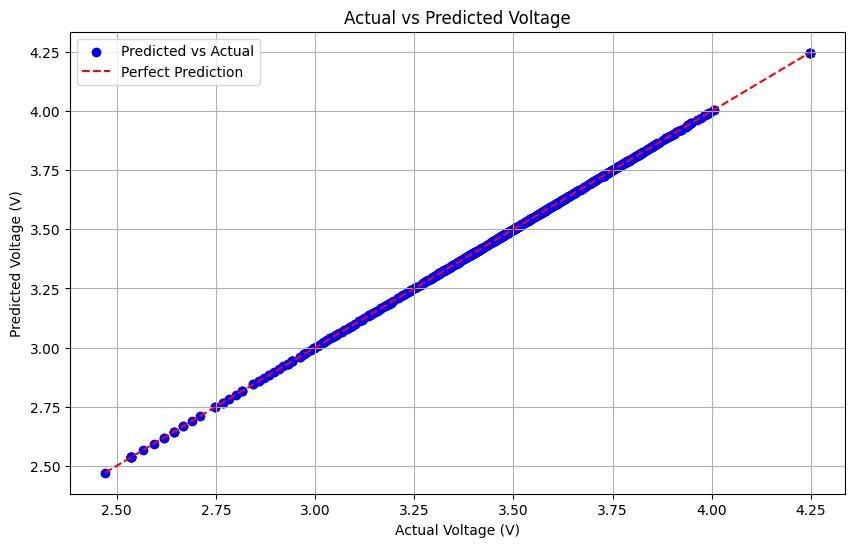

R² Score (Accuracy): 100.00%
Consolidated results saved to consolidated_results.csv


In [24]:
import zipfile
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
# Unzip the datas1.zip file and load all CSV files
def unzip_and_load_data(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall("/content")
    # List all CSV files extracted
    csv_files = [f for f in os.listdir('/content') if f.endswith('.csv')]
    return csv_files
# Function to read and combine data from multiple CSV files
def load_and_combine_data(csv_files):
    all_data = []
    for file in csv_files:
        file_path = os.path.join('/content', file)
        df = pd.read_csv(file_path)
        # Assuming the required columns are always present, adjust column names as needed
        required_columns = ["Voltage_measured", "Current_measured", "Temperature_measured",
                            "Current_load", "Voltage_load", "Time"]
        if all(col in df.columns for col in required_columns):
            df = df[required_columns]  # Filter to only the required columns
            all_data.append(df)
        else:
            print(f"Missing columns in {file}, skipping file.")
    combined_data = pd.concat(all_data, ignore_index=True)
    return combined_data
# Function to preprocess the data
def preprocess_data(df):
    # Check for missing values and handle them
    df = df.dropna()  # Dropping rows with missing values, or impute if needed
    X = df.drop("Voltage_measured", axis=1)  # Features (excluding the target)
    y = df["Voltage_measured"]  # Target (Voltage to predict)
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, y
# Function to train and optimize the model
def train_model(X, y):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Use RandomForestRegressor or other models like XGBoost
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    # Optionally perform hyperparameter tuning (for example, grid search)
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(model, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    # Predict and evaluate the model
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R² Score: {r2}")
    print(f"Mean Absolute Error: {mae}")
    return best_model, y_test, y_pred
# Function to generate graphs and show accuracy
def generate_graphs_and_accuracy(y_test, y_pred):
    # Plot actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Voltage (V)')
    plt.ylabel('Predicted Voltage (V)')
    plt.title('Actual vs Predicted Voltage')
    plt.legend()
    plt.grid(True)
    plt.show()
    # Calculate accuracy as R² Score
    r2 = r2_score(y_test, y_pred)
    print(f"R² Score (Accuracy): {r2 * 100:.2f}%")
# Main function to process the data and train the model
def main(zip_file_path):
    # Step 1: Unzip and load data
    csv_files = unzip_and_load_data(zip_file_path)
    # Step 2: Combine and preprocess data
    combined_data = load_and_combine_data(csv_files)
    X_scaled, y = preprocess_data(combined_data)
    # Step 3: Train the model and evaluate
    model, y_test, y_pred = train_model(X_scaled, y)
    # Step 4: Generate graphs and calculate accuracy
    generate_graphs_and_accuracy(y_test, y_pred)
    combined_data['Predicted_Voltage'] = model.predict(X_scaled)
    combined_data.to_csv("/content/consolidated_results.csv", index=False)
    print("Consolidated results saved to consolidated_results.csv")
if __name__ == "__main__":
    zip_file_path = "/content/datas1.zip"
    main(zip_file_path)
